# MultiClass Classification

There are some basic changes required compared to the binary classification done earlier.

- We change the `class_mode` in image data generator from `'binary'` to `'categorical'`.
- We change the last layer from 1 node to the number of classes we need to classify number of nodes
- We change the activation of last layer from `sigmoid` to `softmax`
- We change the loss from `binary_crossentropy` to `categorical_crossentropy`

In [1]:
import tensorflow as tf
tf.config.experimental.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]

## Example

Using Transfer learning for better Results

In [1]:
!mkdir -p dataset/inception
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \-O dataset/inception/inception_v3.h5

--2020-10-29 21:28:11--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:400a:802::2010, 2a00:1450:400a:800::2010, 2a00:1450:400a:801::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:400a:802::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘dataset/inception/inception_v3.h5’

dataset/inception/i 100%[===================>]  83.84M  4.11MB/s    in 24s     

2020-10-29 21:28:37 (3.56 MB/s) - ‘dataset/inception/inception_v3.h5’ saved [87910968/87910968]



In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
skeleton_model = InceptionV3(input_shape=(300,300, 3), include_top=False, weights=None)

In [5]:
skeleton_model.load_weights('dataset/inception/inception_v3.h5')

In [6]:
for layer in skeleton_model.layers:
    layer.trainable = False

In [7]:
last_layer = skeleton_model.get_layer('mixed7')

### Last Layer

Here we have 3 nodes in last layer compared to 1 in binary classification.Also note that the activation has changed from 'sigmoid' to 'softmax' as the number of nodes are not just 1, but more than 1

In [8]:
x = tf.keras.layers.Flatten()(last_layer.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

In [9]:
transfered_model = tf.keras.models.Model(skeleton_model.inputs, x)

### Loss updated

Here in place of using a binary_crossentropy we are using a categorical_crossentropy as the number of classes are more than 2 here

In [10]:
transfered_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
transfered_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
import os

In [13]:
folders = os.listdir('dataset/rock_paper_scissors/rps')
for folder in folders:
    print(folder,':', len(os.listdir(os.path.join('dataset/rock_paper_scissors/rps', folder))))

scissors : 840
paper : 840
rock : 840


In [14]:
folders = os.listdir('dataset/rock_paper_scissors/rps-test-set')
for folder in folders:
    print(folder,':', len(os.listdir(os.path.join('dataset/rock_paper_scissors/rps-test-set', folder))))

scissors : 124
paper : 124
rock : 124


### Data Generators

The class_mode parameter here will use the value `categorical` in place of `binary` for multiclass classification.

In [15]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    'dataset/rock_paper_scissors/rps',
    target_size=(300,300),
    batch_size=120, #steps = 7
    class_mode='categorical'
)

Found 2520 images belonging to 3 classes.


In [16]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)
validation_generator = validation_datagen.flow_from_directory(
    'dataset/rock_paper_scissors/rps-test-set',
    target_size=(300,300),
    batch_size=124,
    class_mode='categorical'
)

Found 372 images belonging to 3 classes.


In [17]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >0.95:
            print('\nReached 95% accuracy. Now Stopping!!')
            self.model.stop_training=True

In [18]:
training_history = transfered_model.fit(
    train_generator,
    steps_per_epoch=7,
    validation_data=validation_generator,
    validation_steps=1,
    epochs=100,
    callbacks=[MyCallback()],
    verbose=1
)

Epoch 1/100
7/7 [==============================] - 20s 3s/step - loss: 161.6658 - accuracy: 0.3440 - val_loss: 39.4502 - val_accuracy: 0.6694
Epoch 2/100
7/7 [==============================] - 18s 3s/step - loss: 26.7812 - accuracy: 0.5012 - val_loss: 26.4548 - val_accuracy: 0.3065
Epoch 3/100
7/7 [==============================] - 18s 3s/step - loss: 16.7478 - accuracy: 0.5643 - val_loss: 6.8108 - val_accuracy: 0.4597
Epoch 4/100
7/7 [==============================] - 18s 3s/step - loss: 4.1389 - accuracy: 0.8524 - val_loss: 0.6463 - val_accuracy: 0.8952
Epoch 5/100
7/7 [==============================] - 18s 3s/step - loss: 10.2601 - accuracy: 0.7250 - val_loss: 7.6602 - val_accuracy: 0.6129
Epoch 6/100
7/7 [==============================] - 18s 3s/step - loss: 21.9059 - accuracy: 0.5667 - val_loss: 23.1982 - val_accuracy: 0.6694
Epoch 7/100
7/7 [==============================] - 18s 3s/step - loss: 1.8140 - accuracy: 0.9333 - val_loss: 1.9219 - val_accuracy: 0.8226
Epoch 8/100
7/7 [=

In [19]:
import matplotlib.pyplot as plt

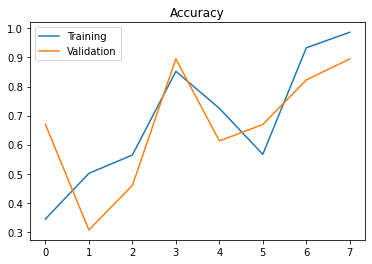

In [22]:
plt.plot(training_history.history['accuracy'], label='Training')
plt.plot(training_history.history['val_accuracy'], label='Validation')
plt.legend(loc='best')
plt.title('Accuracy')
plt.show()

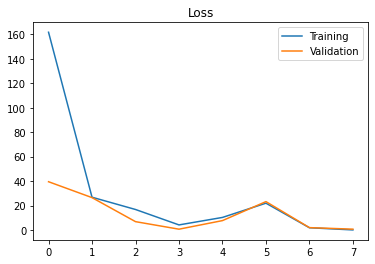

In [21]:
plt.plot(training_history.history['loss'], label='Training')
plt.plot(training_history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend(loc='best')